In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import ast  # This is for safely converting string-lists to lists
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MultiLabelBinarizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate

# Load the NEW smart dataset
data_path = '../data/processed/processed_oven_recipes_v2.csv'
df = pd.read_csv(data_path)

# Drop any rows with missing values (just in case)
df.dropna(inplace=True)

# Let's train only on "good" recipes (rating >= 4)
df_model_data = df[df['rating'] >= 4].copy()

print(f"Loaded {len(df_model_data)} high-rated smart recipes for training.")
df_model_data.head()

Loaded 50656 high-rated smart recipes for training.


,id,name,rating,Room_Temp,Room_Humidity,ingredient_ids,tags,Oven_Temp,Oven_Duration
0,137739,arriba baked winter squash mexican style,5.000000,20.5,67.5,"[7933, 4694, 4795, 3723, 840, 5006, 6270]","['60-minutes-or-less', 'time-to-make', 'course...",350.0,40.0
2,59389,alouette potatoes,4.000000,25.5,50.3,"[1170, 4918, 6426, 5185, 7099, 5006, 6009, 627...","['60-minutes-or-less', 'time-to-make', 'course...",350.0,120.0
3,75452,beat this banana bread,4.250000,24.9,35.8,"[6906, 7367, 342, 2499, 2832, 5068, 911, 335, ...","['weeknight', 'time-to-make', 'course', 'main-...",350.0,50.0
5,25775,how i got my family to eat spinach spinach ca...,4.060241,24.9,59.5,"[2984, 2499, 6270, 590, 5010, 1168, 1674, 1974]","['60-minutes-or-less', 'time-to-make', 'course...",350.0,37.0
6,93958,i yam what i yam muffins,5.000000,19.1,50.3,"[63, 815, 7406, 332, 335, 6270, 3497, 3498, 66...","['60-minutes-or-less', 'time-to-make', 'course...",375.0,17.0


In [2]:
print("Converting text-based lists...")
df_model_data['ingredient_ids'] = df_model_data['ingredient_ids'].apply(ast.literal_eval)
df_model_data['tags'] = df_model_data['tags'].apply(ast.literal_eval)
print("Conversion complete.")


# --- 2. Define Features (X) and Targets (Y) ---
X_name = df_model_data[['name']]
X_env = df_model_data[['Room_Temp', 'Room_Humidity']]
X_ingredients = df_model_data['ingredient_ids']
X_tags = df_model_data['tags']

Y = df_model_data[['Oven_Temp', 'Oven_Duration']]


# --- 3. Preprocess Inputs ---

# Input A: Dish Name (Same as before)
name_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_name_encoded = name_encoder.fit_transform(X_name)
num_unique_dishes = len(name_encoder.categories_[0])
print(f"Total unique dishes: {num_unique_dishes}")

# Input B: Environment (Same as before)
env_scaler = StandardScaler()
X_env_scaled = env_scaler.fit_transform(X_env)

# Input C: Ingredients (NEW!)
# We use MultiLabelBinarizer to create a "bag of words" vector
# e.g., [0, 1, 0, 1, 1, 0, ...] where a 1 means that ingredient is present.
ingredient_binarizer = MultiLabelBinarizer()
X_ingredients_encoded = ingredient_binarizer.fit_transform(X_ingredients)
num_unique_ingredients = len(ingredient_binarizer.classes_)
print(f"Total unique ingredients: {num_unique_ingredients}")

# Input D: Tags (NEW!)
# We do the same for tags.
tag_binarizer = MultiLabelBinarizer()
X_tags_encoded = tag_binarizer.fit_transform(X_tags)
num_unique_tags = len(tag_binarizer.classes_)
print(f"Total unique tags: {num_unique_tags}")


# --- 4. Preprocess Outputs (Same as before) ---
output_scaler = StandardScaler()
Y_scaled = output_scaler.fit_transform(Y)


# --- 5. Split ALL Data for Training ---
# We must split all 4 inputs and 1 output together
(X_name_train, X_name_test,
 X_env_train, X_env_test,
 X_ingr_train, X_ingr_test,
 X_tags_train, X_tags_test,
 Y_train, Y_test) = train_test_split(
    X_name_encoded,
    X_env_scaled,
    X_ingredients_encoded,
    X_tags_encoded,
    Y_scaled,
    test_size=0.2,
    random_state=42
)

print(f"\nTraining data shapes:")
print(f"Name: {X_name_train.shape}")
print(f"Env: {X_env_train.shape}")
print(f"Ingredients: {X_ingr_train.shape}")
print(f"Tags: {X_tags_train.shape}")
print(f"Outputs: {Y_train.shape}")

Converting text-based lists...
Conversion complete.
Total unique dishes: 50413
Total unique ingredients: 5841
Total unique tags: 493

Training data shapes:
Name: (40524, 1)
Env: (40524, 2)
Ingredients: (40524, 5841)
Tags: (40524, 493)
Outputs: (40524, 2)


In [3]:
name_input = Input(shape=(1,), name='name_input')
# Input B: Environment
env_input = Input(shape=(2,), name='env_input')
# Input C: Ingredients
ingredient_input = Input(shape=(num_unique_ingredients,), name='ingredient_input')
# Input D: Tags
tag_input = Input(shape=(num_unique_tags,), name='tag_input')


# --- 2. Process Each Input Branch ---
# Branch A: Dish Name (Embedding)
name_embedding = Embedding(input_dim=num_unique_dishes, output_dim=10, name='name_embedding')(name_input)
name_vec = Flatten()(name_embedding)

# Branch B: Environment (Pass-through)
env_vec = env_input

# Branch C: Ingredients (Compress the wide vector)
# We compress 2000+ ingredients down to 128 features
ingredient_vec = Dense(128, activation='relu', name='ingredient_dense')(ingredient_input)

# Branch D: Tags (Compress the wide vector)
# We compress 500+ tags down to 64 features
tag_vec = Dense(64, activation='relu', name='tag_dense')(tag_input)


# --- 3. Combine All Branches ---
combined_features = Concatenate()([name_vec, env_vec, ingredient_vec, tag_vec])


# --- 4. Model Body ---
x = Dense(128, activation='relu')(combined_features)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)


# --- 5. Define the two Output Heads ---
output_temp = Dense(1, name='temp_output')(x)
output_duration = Dense(1, name='duration_output')(x)


# --- 6. Create and Compile the Model ---
model_v2 = Model(
    inputs=[name_input, env_input, ingredient_input, tag_input], # 4 inputs
    outputs=[output_temp, output_duration] # 2 outputs
)

model_v2.compile(optimizer='adam', 
                 loss='mse', # Mean Squared Error
                 metrics={'temp_output': 'mae', 'duration_output': 'mae'}) # Mean Absolute Error

model_v2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ name_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ name_embedding      │ (None, 1, 10)     │    504,130 │ name_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ingredient_input    │ (None, 5841)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tag_input           │ (None, 493)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10)        │          0 │ name_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ env_input           │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ingredient_dense    │ (None, 128)       │    747,776 │ ingredient_input… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tag_dense (Dense)   │ (None, 64)        │     31,616 │ tag_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 204)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ env_input[0][0],  │
│                     │                   │            │ ingredient_dense… │
│                     │                   │            │ tag_dense[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     26,240 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temp_output (Dense) │ (None, 1)         │         33 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_output     │ (None, 1)         │         33 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,320,164 (5.04 MB)

 Trainable params: 1,320,164 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("Starting smart model training...")

# Split the Y arrays for the two output heads
Y_temp_train = Y_train[:, 0]
Y_duration_train = Y_train[:, 1]
Y_temp_test = Y_test[:, 0]
Y_duration_test = Y_test[:, 1]

# Package the inputs and outputs as lists
X_train_list = [X_name_train, X_env_train, X_ingr_train, X_tags_train]
X_test_list = [X_name_test, X_env_test, X_ingr_test, X_tags_test]

Y_train_list = [Y_temp_train, Y_duration_train]
Y_test_list = [Y_temp_test, Y_duration_test]


history = model_v2.fit(
    X_train_list,  # List of 4 input arrays
    Y_train_list,  # List of 2 output arrays
    validation_data=(
        X_test_list,
        Y_test_list
    ),
    epochs=50, 
    batch_size=32,
    verbose=1
)

print("Training complete.")

Starting smart model training...
Epoch 1/5
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - duration_output_loss: 0.8974 - duration_output_mae: 0.2395 - loss: 1.3382 - temp_output_loss: 0.4402 - temp_output_mae: 0.4100 - val_duration_output_loss: 0.7449 - val_duration_output_mae: 0.2584 - val_loss: 1.4490 - val_temp_output_loss: 0.7043 - val_temp_output_mae: 0.5502
Epoch 2/5
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - duration_output_loss: 0.6461 - duration_output_mae: 0.2097 - loss: 0.8619 - temp_output_loss: 0.2156 - temp_output_mae: 0.2913 - val_duration_output_loss: 0.7761 - val_duration_output_mae: 0.2443 - val_loss: 1.4423 - val_temp_output_loss: 0.6661 - val_temp_output_mae: 0.5178
Epoch 3/5
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - duration_output_loss: 0.4195 - duration_output_mae: 0.1756 - loss: 0.5170 - temp_output_loss: 0.0972 - temp_output_mae: 0.1833 - val_duration_output_loss: 0.8499 - val_duration_output_mae: 0.2642 - val_loss: 1.5252 - val_temp_output_loss: 0.676

In [6]:
# --- 1. Save the TensorFlow/Keras Model ---
model_path = '../ml_model/models/oven_predictor_v2.h5'
model_v2.save(model_path)
print(f"Smart model saved to: {model_path}")

# --- 2. Save ALL Preprocessors ---
print("Saving preprocessors...")
with open('../ml_model/models/name_encoder_v2.pkl', 'wb') as f:
    pickle.dump(name_encoder, f)
    
with open('../ml_model/models/env_scaler_v2.pkl', 'wb') as f:
    pickle.dump(env_scaler, f)
    
with open('../ml_model/models/output_scaler_v2.pkl', 'wb') as f:
    pickle.dump(output_scaler, f)
    
with open('../ml_model/models/ingredient_binarizer.pkl', 'wb') as f: # NEW
    pickle.dump(ingredient_binarizer, f)
    
with open('../ml_model/models/tag_binarizer.pkl', 'wb') as f: # NEW
    pickle.dump(tag_binarizer, f)
    
print("All v2 models and preprocessors saved.")

Smart model saved to: ../ml_model/models/oven_predictor_v2.h5
Saving preprocessors...
All v2 models and preprocessors saved.


In [7]:
# --- Let's test the full V2 prediction pipeline ---
# Get a sample row from our dataframe
test_sample = df_model_data.iloc[0] # Get the first 'good' recipe

# --- 1. Get Sample Raw Inputs ---
sample_name = [test_sample['name']]
sample_env = [[test_sample['Room_Temp'], test_sample['Room_Humidity']]]
sample_ingredients = [test_sample['ingredient_ids']] # Already a list
sample_tags = [test_sample['tags']] # Already a list

print("\n--- TEST PREDICTION ---")
print(f"Input Dish: {sample_name[0]}")

# --- 2. Process ALL 4 Inputs ---
sample_name_encoded = name_encoder.transform([sample_name])
sample_env_scaled = env_scaler.transform(sample_env)
sample_ingr_encoded = ingredient_binarizer.transform(sample_ingredients)
sample_tags_encoded = tag_binarizer.transform(sample_tags)

# 3. Package for prediction
X_pred_list = [sample_name_encoded, sample_env_scaled, sample_ingr_encoded, sample_tags_encoded]

# 4. Make Prediction
scaled_pred_temp, scaled_pred_duration = model_v2.predict(X_pred_list)

# 5. Invert Scaling (to get real-world values)
scaled_pred = np.array([[scaled_pred_temp[0][0], scaled_pred_duration[0][0]]])
final_prediction = output_scaler.inverse_transform(scaled_pred)

print(f"\n== AI V2 Prediction ==")
print(f"Predicted Temp: {final_prediction[0][0]:.0f}°F")
print(f"Predicted Duration: {final_prediction[0][1]:.0f} minutes")

print(f"\n== Actual 'Good' Value from Dataset ==")
print(f"Actual Temp: {test_sample['Oven_Temp']:.0f}°F")
print(f"Actual Duration: {test_sample['Oven_Duration']:.0f} minutes")


--- TEST PREDICTION ---
Input Dish: arriba   baked winter squash mexican style


d:\smart-oven-aiot\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(
d:\smart-oven-aiot\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

== AI V2 Prediction ==
Predicted Temp: 324°F
Predicted Duration: 29 minutes

== Actual 'Good' Value from Dataset ==
Actual Temp: 350°F
Actual Duration: 40 minutes


In [8]:
# Get the MAE for the final epoch
final_temp_mae = history.history['val_temp_output_mae'][-1]
final_duration_mae = history.history['val_duration_output_mae'][-1]

print(f"Final Scaled Temp MAE: {final_temp_mae:.4f}")
print(f"Final Scaled Duration MAE: {final_duration_mae:.4f}")

# --- Convert this to real-world values ---
# We can't directly convert the MAE, but we can look at the output_scaler's scale
scale = output_scaler.scale_
print(f"\nModel predicts, on average:")
print(f"Temperature within approx. ±{final_temp_mae * scale[0]:.1f} degrees F")
print(f"Duration within approx. ±{final_duration_mae * scale[1]:.1f} minutes")

Final Scaled Temp MAE: 0.5170
Final Scaled Duration MAE: 0.2443

Model predicts, on average:
Temperature within approx. ±29.6 degrees F
Duration within approx. ±30.4 minutes


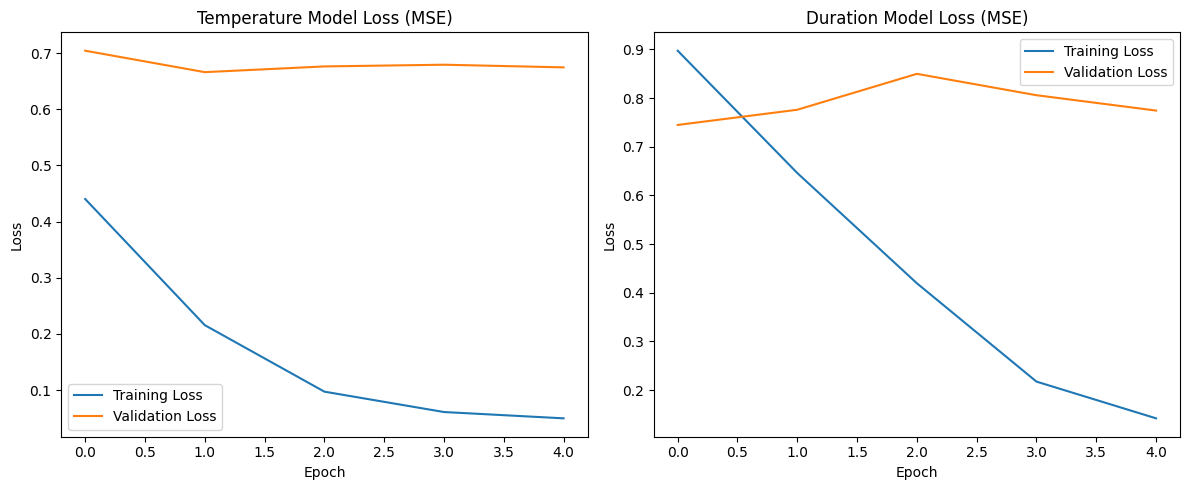

In [9]:
import matplotlib.pyplot as plt

# --- Plot 1: Temperature Loss ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['temp_output_loss'], label='Training Loss')
plt.plot(history.history['val_temp_output_loss'], label='Validation Loss')
plt.title('Temperature Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# --- Plot 2: Duration Loss ---
plt.subplot(1, 2, 2)
plt.plot(history.history['duration_output_loss'], label='Training Loss')
plt.plot(history.history['val_duration_output_loss'], label='Validation Loss')
plt.title('Duration Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MultiLabelBinarizer
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Re-run data loading and initial filtering
data_path = 'D:\smart-oven-aiot\data\processed\processed_oven_recipes_v2.csv'
df = pd.read_csv(data_path)

df.dropna(inplace=True)

df_model_data = df[df['rating'] >= 4].copy()

print(f"Loaded {len(df_model_data)} high-rated smart recipes for training.")

# Re-run data preprocessing and splitting
print("Converting text-based lists...")
df_model_data['ingredient_ids'] = df_model_data['ingredient_ids'].apply(ast.literal_eval)
df_model_data['tags'] = df_model_data['tags'].apply(ast.literal_eval)
print("Conversion complete.")

X_name = df_model_data[['name']]
X_env = df_model_data[['Room_Temp', 'Room_Humidity']]
X_ingredients = df_model_data['ingredient_ids']
X_tags = df_model_data['tags']

Y = df_model_data[['Oven_Temp', 'Oven_Duration']]

# Re-initialize and fit preprocessors and scalers
name_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_name_encoded = name_encoder.fit_transform(X_name)
num_unique_dishes = len(name_encoder.categories_[0])
print(f"Total unique dishes: {num_unique_dishes}")

env_scaler = StandardScaler()
X_env_scaled = env_scaler.fit_transform(X_env)

ingredient_binarizer = MultiLabelBinarizer()
X_ingredients_encoded = ingredient_binarizer.fit_transform(X_ingredients)
num_unique_ingredients = len(ingredient_binarizer.classes_)
print(f"Total unique ingredients: {num_unique_ingredients}")

tag_binarizer = MultiLabelBinarizer()
X_tags_encoded = tag_binarizer.fit_transform(X_tags)
num_unique_tags = len(tag_binarizer.classes_)
print(f"Total unique tags: {num_unique_tags}")

output_scaler = StandardScaler()
Y_scaled = output_scaler.fit_transform(Y)

(X_name_train, X_name_test,
 X_env_train, X_env_test,
 X_ingr_train, X_ingr_test,
 X_tags_train, X_tags_test,
 Y_train, Y_test) = train_test_split(
    X_name_encoded,
    X_env_scaled,
    X_ingredients_encoded,
    X_tags_encoded,
    Y_scaled,
    test_size=0.2,
    random_state=42
)

print(f"\nTraining data shapes:")
print(f"Name: {X_name_train.shape}")
print(f"Env: {X_env_train.shape}")
print(f"Ingredients: {X_ingr_train.shape}")
print(f"Tags: {X_tags_train.shape}")
print(f"Outputs: {Y_train.shape}")

print("\nPreparing data for Scikit-learn models...")

# Combine the different input arrays into single matrices for train and test sets
X_train_combined = np.hstack((X_name_train, X_env_train, X_ingr_train, X_tags_train))
X_test_combined = np.hstack((X_name_test, X_env_test, X_ingr_test, X_tags_test))

print(f"Combined Training Input Shape: {X_train_combined.shape}")
print(f"Combined Testing Input Shape: {X_test_combined.shape}")
print(f"Training Output Shape: {Y_train.shape}")
print(f"Testing Output Shape: {Y_test.shape}")

print("\nExploring LightGBM and CatBoost models...")

# Instantiate separate models for Temperature and Duration for LightGBM and CatBoost
lgbm_model_temp = LGBMRegressor(random_state=42)
lgbm_model_duration = LGBMRegressor(random_state=42)

catboost_model_temp = CatBoostRegressor(random_state=42, verbose=0)
catboost_model_duration = CatBoostRegressor(random_state=42, verbose=0)

# Split Y_train and Y_test into separate arrays for Temperature and Duration
Y_train_temp = Y_train[:, 0]
Y_train_duration = Y_train[:, 1]
Y_test_temp = Y_test[:, 0]
Y_test_duration = Y_test[:, 1]

# Train the models for Temperature
print("Training LightGBM for Temperature...")
lgbm_model_temp.fit(X_train_combined, Y_train_temp)

print("Training CatBoost for Temperature...")
catboost_model_temp.fit(X_train_combined, Y_train_temp)

# Train the models for Duration
print("Training LightGBM for Duration...")
lgbm_model_duration.fit(X_train_combined, Y_train_duration)

print("Training CatBoost for Duration...")
catboost_model_duration.fit(X_train_combined, Y_train_duration)

# Predict on the test set
print("Predicting with LightGBM and CatBoost...")
y_pred_scaled_lgbm_temp = lgbm_model_temp.predict(X_test_combined)
y_pred_scaled_lgbm_duration = lgbm_model_duration.predict(X_test_combined)

y_pred_scaled_catboost_temp = catboost_model_temp.predict(X_test_combined)
y_pred_scaled_catboost_duration = catboost_model_duration.predict(X_test_combined)

# Combine predictions for inverse transformation
y_pred_scaled_lgbm = np.vstack((y_pred_scaled_lgbm_temp, y_pred_scaled_lgbm_duration)).T
y_pred_scaled_catboost = np.vstack((y_pred_scaled_catboost_temp, y_pred_scaled_catboost_duration)).T

# Inverse transform predictions and true values
y_pred_original_lgbm = output_scaler.inverse_transform(y_pred_scaled_lgbm)
y_pred_original_catboost = output_scaler.inverse_transform(y_pred_scaled_catboost)
y_test_original = output_scaler.inverse_transform(Y_test) # Y_test is the scaled version

# Calculate and store metrics for LightGBM
print("\n--- Evaluating LightGBM ---")
mae_temp_lgbm = mean_absolute_error(y_test_original[:, 0], y_pred_original_lgbm[:, 0])
mse_temp_lgbm = mean_squared_error(y_test_original[:, 0], y_pred_original_lgbm[:, 0])
rmse_temp_lgbm = np.sqrt(mse_temp_lgbm)
r2_temp_lgbm = r2_score(y_test_original[:, 0], y_pred_original_lgbm[:, 0])

mae_duration_lgbm = mean_absolute_error(y_test_original[:, 1], y_pred_original_lgbm[:, 1])
mse_duration_lgbm = mean_squared_error(y_test_original[:, 1], y_pred_original_lgbm[:, 1])
rmse_duration_lgbm = np.sqrt(mse_duration_lgbm)
r2_duration_lgbm = r2_score(y_test_original[:, 1], y_pred_original_lgbm[:, 1])

# Ensure the results dictionary is initialized or updated to include previous models if needed
results = {}

results["LightGBM"] = {
    "Temp MAE": mae_temp_lgbm, "Temp MSE": mse_temp_lgbm, "Temp RMSE": rmse_temp_lgbm, "Temp R2": r2_temp_lgbm,
    "Duration MAE": mae_duration_lgbm, "Duration MSE": mse_duration_lgbm, "Duration RMSE": rmse_duration_lgbm, "Duration R2": r2_duration_lgbm
}

print("LightGBM Results:")
print(f"  Temp: MAE={mae_temp_lgbm:.2f}, MSE={mse_temp_lgbm:.2f}, RMSE={rmse_temp_lgbm:.2f}, R2={r2_temp_lgbm:.3f}")
print(f"  Duration: MAE={mae_duration_lgbm:.2f}, MSE={mse_duration_lgbm:.2f}, RMSE={rmse_duration_lgbm:.2f}, R2={r2_duration_lgbm:.3f}")

# Calculate and store metrics for CatBoost
print("\n--- Evaluating CatBoost ---")
mae_temp_catboost = mean_absolute_error(y_test_original[:, 0], y_pred_original_catboost[:, 0])
mse_temp_catboost = mean_squared_error(y_test_original[:, 0], y_pred_original_catboost[:, 0])
rmse_temp_catboost = np.sqrt(mse_temp_catboost)
r2_temp_catboost = r2_score(y_test_original[:, 0], y_pred_original_catboost[:, 0])

mae_duration_catboost = mean_absolute_error(y_test_original[:, 1], y_pred_original_catboost[:, 1])
mse_duration_catboost = mean_squared_error(y_test_original[:, 1], y_pred_original_catboost[:, 1])
rmse_duration_catboost = np.sqrt(mse_duration_catboost)
r2_duration_catboost = r2_score(y_test_original[:, 1], y_pred_original_catboost[:, 1])

results["CatBoost"] = {
    "Temp MAE": mae_temp_catboost, "Temp MSE": mse_temp_catboost, "Temp RMSE": rmse_temp_catboost, "Temp R2": r2_temp_catboost,
    "Duration MAE": mae_duration_catboost, "Duration MSE": mse_duration_catboost, "Duration RMSE": rmse_duration_catboost, "Duration R2": r2_duration_catboost
}

print("CatBoost Results:")
print(f"  Temp: MAE={mae_temp_catboost:.2f}, MSE={mse_temp_catboost:.2f}, RMSE={mse_temp_catboost:.2f}, R2={r2_temp_catboost:.3f}")
print(f"  Duration: MAE={mae_duration_catboost:.2f}, MSE={mse_duration_catboost:.2f}, RMSE={rmse_duration_catboost:.2f}, R2={r2_duration_catboost:.3f}")

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
C:\Users\bishn\AppData\Local\Temp\ipykernel_15420\3315561874.py:11: SyntaxWarning: invalid escape sequence '\s'
  data_path = 'D:\smart-oven-aiot\data\processed\processed_oven_recipes_v2.csv'


Loaded 50656 high-rated smart recipes for training.
Converting text-based lists...
Conversion complete.
Total unique dishes: 50413
Total unique ingredients: 5841
Total unique tags: 493

Training data shapes:
Name: (40524, 1)
Env: (40524, 2)
Ingredients: (40524, 5841)
Tags: (40524, 493)
Outputs: (40524, 2)

Preparing data for Scikit-learn models...
Combined Training Input Shape: (40524, 6337)
Combined Testing Input Shape: (10132, 6337)
Training Output Shape: (40524, 2)
Testing Output Shape: (10132, 2)

Exploring LightGBM and CatBoost models...
Training LightGBM for Temperature...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3876
[LightGBM] [Info] Number of data points in the train set: 40524, number of used features: 1613
[LightGBM] [Info] Start training from score -0.001992
Train

d:\smart-oven-aiot\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
d:\smart-oven-aiot\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



--- Evaluating LightGBM ---
LightGBM Results:
  Temp: MAE=29.00, MSE=2139.65, RMSE=46.26, R2=0.343
  Duration: MAE=30.77, MSE=11528.64, RMSE=107.37, R2=0.100

--- Evaluating CatBoost ---
CatBoost Results:
  Temp: MAE=28.99, MSE=2109.35, RMSE=2109.35, R2=0.352
  Duration: MAE=29.32, MSE=11831.11, RMSE=108.77, R2=0.076




--- Model Comparison ---


,Temp MAE,Temp MSE,Temp RMSE,Temp R2,Duration MAE,Duration MSE,Duration RMSE,Duration R2
LightGBM,29.002,2139.652,46.256,0.343,30.770,11528.637,107.371,0.100
CatBoost,28.993,2109.353,45.928,0.352,29.324,11831.111,108.771,0.076


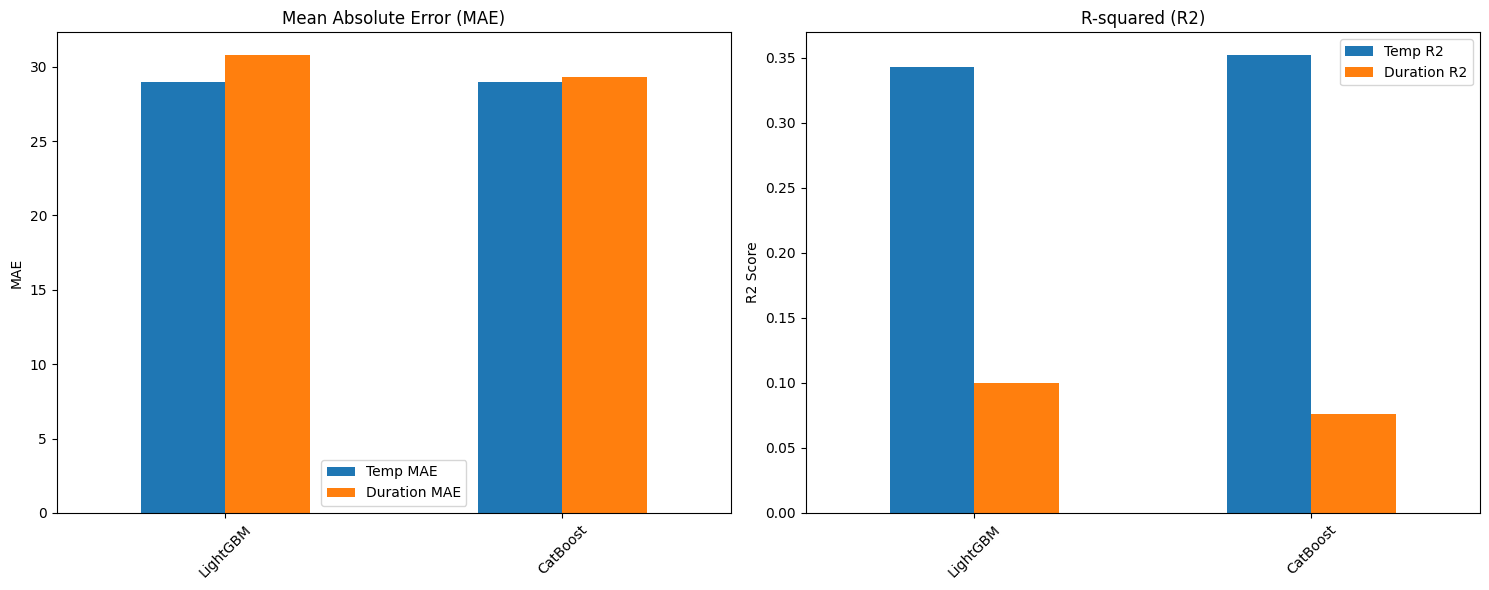

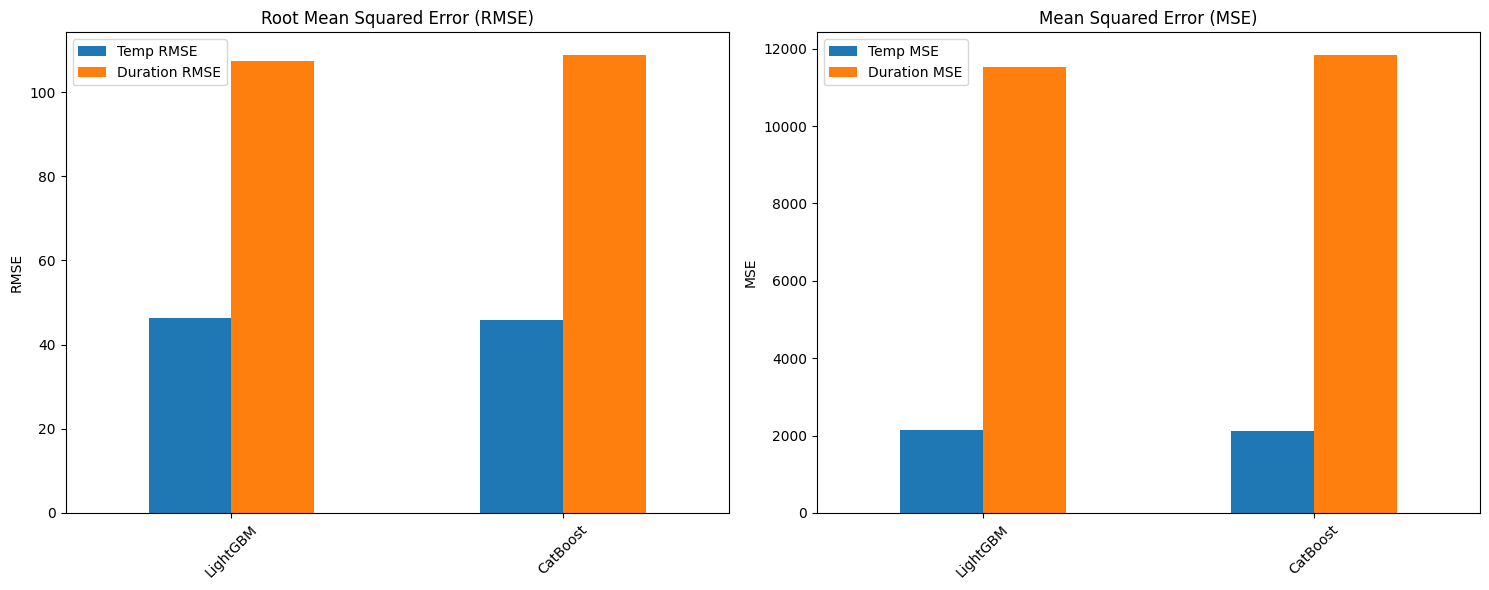

In [12]:
import matplotlib.pyplot as plt

comparison_df = pd.DataFrame(results).T # Transpose to have models as rows
print("\n\n--- Model Comparison ---")
# Display with formatted numbers
pd.options.display.float_format = '{:.3f}'.format
display(comparison_df)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

comparison_df[['Temp MAE', 'Duration MAE']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_ylabel('MAE')
axes[0].tick_params(axis='x', rotation=45)

# Plot R2 for Temperature and Duration
comparison_df[['Temp R2', 'Duration R2']].plot(kind='bar', ax=axes[1])
axes[1].set_title('R-squared (R2)')
axes[1].set_ylabel('R2 Score')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Plot RMSE for Temperature and Duration
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

comparison_df[['Temp RMSE', 'Duration RMSE']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Root Mean Squared Error (RMSE)')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)

# Plot MSE for Temperature and Duration
comparison_df[['Temp MSE', 'Duration MSE']].plot(kind='bar', ax=axes[1])
axes[1].set_title('Mean Squared Error (MSE)')
axes[1].set_ylabel('MSE')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [13]:
# In model_prototyping.ipynb - New Cell

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("Preparing data for Scikit-learn models...")

# Combine the different input arrays into single matrices for train and test sets
# X_name_train, X_env_train, X_ingr_train, X_tags_train are from the train_test_split cell

# Concatenate horizontally: (name_encoded, env_scaled, ingredients_encoded, tags_encoded)
X_train_combined = np.hstack((X_name_train, X_env_train, X_ingr_train, X_tags_train))
X_test_combined = np.hstack((X_name_test, X_env_test, X_ingr_test, X_tags_test))

# Y_train and Y_test are already the scaled [n_samples, 2] arrays (Temp, Duration)
# We use the scaled Y values for consistency across models

print(f"Combined Training Input Shape: {X_train_combined.shape}")
print(f"Combined Testing Input Shape: {X_test_combined.shape}")
print(f"Training Output Shape: {Y_train.shape}")
print(f"Testing Output Shape: {Y_test.shape}")

Preparing data for Scikit-learn models...
Combined Training Input Shape: (40524, 6337)
Combined Testing Input Shape: (10132, 6337)
Training Output Shape: (40524, 2)
Testing Output Shape: (10132, 2)


In [14]:
# In model_prototyping.ipynb - New Cell

# --- Define models ---
print("Defining comparison models...")
#rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20, min_samples_split=10) # Added some reasonable hyperparameters
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1, max_depth=10) # Added max_depth
mlp_model = MLPRegressor(hidden_layer_sizes=(128, 64, 32), random_state=42, max_iter=100, early_stopping=True, n_iter_no_change=10) # Reduced max_iter, added early stopping

models = {
    #"RandomForest": rf_model,
    "XGBoost": xgb_model,
    "MLP": mlp_model
}

# --- Train and Evaluate ---
print("Training and evaluating comparison models...")

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train_combined, Y_train) # Train on combined input and scaled output

    print(f"--- Evaluating {name} ---")
    y_pred_scaled = model.predict(X_test_combined)

    # Inverse transform predictions AND true values to get metrics in original units
    y_pred_original = output_scaler.inverse_transform(y_pred_scaled)
    y_test_original = output_scaler.inverse_transform(Y_test) # Y_test is the scaled version

    # Calculate metrics for Temperature (Output 0)
    mae_temp = mean_absolute_error(y_test_original[:, 0], y_pred_original[:, 0])
    mse_temp = mean_squared_error(y_test_original[:, 0], y_pred_original[:, 0])
    rmse_temp = np.sqrt(mse_temp)
    r2_temp = r2_score(y_test_original[:, 0], y_pred_original[:, 0])

    # Calculate metrics for Duration (Output 1)
    mae_duration = mean_absolute_error(y_test_original[:, 1], y_pred_original[:, 1])
    mse_duration = mean_squared_error(y_test_original[:, 1], y_pred_original[:, 1])
    rmse_duration = np.sqrt(mse_duration)
    r2_duration = r2_score(y_test_original[:, 1], y_pred_original[:, 1])

    results[name] = {
        "Temp MAE": mae_temp, "Temp MSE": mse_temp, "Temp RMSE": rmse_temp, "Temp R2": r2_temp,
        "Duration MAE": mae_duration, "Duration MSE": mse_duration, "Duration RMSE": rmse_duration, "Duration R2": r2_duration
    }

    print(f"{name} Results:")
    print(f"  Temp: MAE={mae_temp:.2f}, MSE={mse_temp:.2f}, RMSE={rmse_temp:.2f}, R2={r2_temp:.3f}")
    print(f"  Duration: MAE={mae_duration:.2f}, MSE={mse_duration:.2f}, RMSE={rmse_duration:.2f}, R2={r2_duration:.3f}")

# --- Evaluate the Keras MIMO Model (50 Epochs) ---
print("\n--- Evaluating Keras MIMO (50 Epochs) ---")
# Use the X_test_list defined earlier for Keras
y_pred_scaled_keras = model_v2.predict(X_test_list)

# Keras predict returns a list [temp_preds, duration_preds], need to stack them
y_pred_scaled_keras_stacked = np.hstack(y_pred_scaled_keras)
y_pred_original_keras = output_scaler.inverse_transform(y_pred_scaled_keras_stacked)
# y_test_original is the same as calculated above

# Metrics for Keras Temp
mae_temp_keras = mean_absolute_error(y_test_original[:, 0], y_pred_original_keras[:, 0])
mse_temp_keras = mean_squared_error(y_test_original[:, 0], y_pred_original_keras[:, 0])
rmse_temp_keras = np.sqrt(mse_temp_keras)
r2_temp_keras = r2_score(y_test_original[:, 0], y_pred_original_keras[:, 0])

# Metrics for Keras Duration
mae_duration_keras = mean_absolute_error(y_test_original[:, 1], y_pred_original_keras[:, 1])
mse_duration_keras = mean_squared_error(y_test_original[:, 1], y_pred_original_keras[:, 1])
rmse_duration_keras = np.sqrt(mse_duration_keras)
r2_duration_keras = r2_score(y_test_original[:, 1], y_pred_original_keras[:, 1])

results["Keras MIMO (50e)"] = {
    "Temp MAE": mae_temp_keras, "Temp MSE": mse_temp_keras, "Temp RMSE": rmse_temp_keras, "Temp R2": r2_temp_keras,
    "Duration MAE": mae_duration_keras, "Duration MSE": mse_duration_keras, "Duration RMSE": rmse_duration_keras, "Duration R2": r2_duration_keras
}

print("Keras MIMO (50e) Results:")
print(f"  Temp: MAE={mae_temp_keras:.2f}, MSE={mse_temp_keras:.2f}, RMSE={rmse_temp_keras:.2f}, R2={r2_temp_keras:.3f}")
print(f"  Duration: MAE={mae_duration_keras:.2f}, MSE={mse_duration_keras:.2f}, RMSE={rmse_duration_keras:.2f}, R2={r2_duration_keras:.3f}")

Defining comparison models...
Training and evaluating comparison models...

--- Training XGBoost ---
--- Evaluating XGBoost ---
XGBoost Results:
  Temp: MAE=29.14, MSE=2176.55, RMSE=46.65, R2=0.331
  Duration: MAE=29.74, MSE=13431.17, RMSE=115.89, R2=-0.049

--- Training MLP ---


d:\smart-oven-aiot\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


--- Evaluating MLP ---
MLP Results:
  Temp: MAE=39.65, MSE=3449.20, RMSE=58.73, R2=-0.059
  Duration: MAE=42.70, MSE=13333.51, RMSE=115.47, R2=-0.041

--- Evaluating Keras MIMO (50 Epochs) ---
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Keras MIMO (50e) Results:
  Temp: MAE=29.60, MSE=2210.23, RMSE=47.01, R2=0.321
  Duration: MAE=30.38, MSE=11981.92, RMSE=109.46, R2=0.064


In [15]:
comparison_df = pd.DataFrame(results).T # Transpose to have models as rows
print("\n\n--- Model Comparison ---")
# Display with formatted numbers
pd.options.display.float_format = '{:.3f}'.format
display(comparison_df)



--- Model Comparison ---


,Temp MAE,Temp MSE,Temp RMSE,Temp R2,Duration MAE,Duration MSE,Duration RMSE,Duration R2
LightGBM,29.002,2139.652,46.256,0.343,30.770,11528.637,107.371,0.100
CatBoost,28.993,2109.353,45.928,0.352,29.324,11831.111,108.771,0.076
XGBoost,29.136,2176.550,46.654,0.331,29.737,13431.170,115.893,-0.049
MLP,39.653,3449.195,58.730,-0.059,42.703,13333.508,115.471,-0.041
Keras MIMO (50e),29.598,2210.234,47.013,0.321,30.380,11981.923,109.462,0.064
